In [ ]:
'''
author: 叶文涛
create time: 2020-7-11
update time: 2020-7-16
'''

In [63]:
#-*- coding: UTF-8 -*-
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, mean_squared_error
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
pd.options.display.max_columns=50
pd.options.display.max_rows=20

In [2]:
# baseline只用到gps定位数据，即train_gps_path
train_gps_path = 'data/clean_data1.pkl'
test_data_path = 'data/R2 ATest 0711.csv'
order_data_path = 'data/loadingOrderEvent.csv'
port_data_path = 'data/port.csv'

In [3]:
%time train_data = pd.read_pickle(train_gps_path) #读取
test_data = pd.read_csv(test_data_path)

train_data.drop(['diff_dist','diff_sec'], axis =1, inplace = True) # 去除cleandata中的两列

Wall time: 13.9 s


In [4]:
# 处理数据
def get_data(data, mode='train'):
    
    assert mode=='train' or mode=='test'
    
    if mode=='train':
        data['vesselNextportETA'] = pd.to_datetime(data['vesselNextportETA'], infer_datetime_format=True)
        data['longitude'] = data['longitude'].astype(float)
        data['latitude'] = data['latitude'].astype(float)
    elif mode=='test':
        data['temp_timestamp'] = data['timestamp']
        data['onboardDate'] = pd.to_datetime(data['onboardDate'], infer_datetime_format=True)
        
    data['timestamp'] = pd.to_datetime(data['timestamp'], infer_datetime_format=True)
    data['longitude'] = data['longitude'].astype(float)
    data['loadingOrder'] = data['loadingOrder'].astype(str)
    data['latitude'] = data['latitude'].astype(float)
    data['speed'] = data['speed'].astype(float)
    data['direction'] = data['direction'].astype(float)
    
    return data

train_data = get_data(train_data, mode='train')
test_data = get_data(test_data, mode='test')

In [5]:
#计算欧式距离，即两点的距离，因为是地球球面模型，所以两点的距离即两点的弧长
def distance(LatA,LatB,LonA,LonB):
    EARTH_RADIUS = 6378.137 # 千米
    
    # 度数转化为弧度
    def rad(d):
        return d * np.pi/ 180.0
    a = rad(LatA)-rad(LatB)
    b = rad(LonA)-rad(LonB)
    
    s= 2 * np.arcsin(np.sqrt(np.sin(a / 2)** 2  + np.cos(rad(LatA)) * np.cos(rad(LatB))* np.sin(b / 2)**2))
    s= s* EARTH_RADIUS
    #  保留两位小数
    s = np.round(s * 100)/100
    s = s * 1000 # 转换成米单位
    return s

# baseline特征
def get_feature1(df, mode='train'):
    
    assert mode=='train' or mode=='test'
    
    df.sort_values(['loadingOrder', 'timestamp'], inplace=True)
    
    group_df = df.groupby('loadingOrder')['timestamp'].agg(mmax='max', count='count', mmin='min').reset_index()
    
    
    if mode=='train':
        # 读取数据的最大值-最小值，即确认时间间隔为label
        group_df['label'] = (group_df['mmax'] - group_df['mmin']).dt.total_seconds()
    elif mode=='test':
        pass

    
    # 种类特征
    group_df['TRANSPORT_TRACE'] = list(df.groupby('loadingOrder')['TRANSPORT_TRACE'].describe()['top'].astype('str'))  # 最多出现的路由
    group_df['carrierName'] = list(df.groupby('loadingOrder')['carrierName'].describe()['top'].astype('str')) 
    group_df['vesselMMSI'] = list(df.groupby('loadingOrder')['vesselMMSI'].describe()['top'].astype('str'))
    # 对类别特征 label encode
    cat_cols = ['TRANSPORT_TRACE', 'carrierName','vesselMMSI']
    for c in cat_cols:
        lb_encoder = LabelEncoder()
        group_df[c] = lb_encoder.fit_transform(group_df[c])
    
    # 始末点经纬度
    group_df['start_lon']=df.groupby('loadingOrder')['longitude'].agg(['first','last']).reset_index()['first']  
    group_df['end_lon']=df.groupby('loadingOrder')['longitude'].agg(['first','last']).reset_index()['last']
    group_df['start_lat']=df.groupby('loadingOrder')['latitude'].agg(['first','last']).reset_index()['first']
    group_df['end_lat']=df.groupby('loadingOrder')['latitude'].agg(['first','last']).reset_index()['last']   
    # 利用始末经纬度计算始末点距离
    group_df['dist']=distance(group_df['start_lat'],group_df['end_lat'],group_df['start_lon'],group_df['end_lon'])
    
    group_df['speed_mean'] = df.groupby('loadingOrder')['speed'].agg('mean').reset_index()['speed']
    
    #is_at_port_sum = df.groupby('loadingOrder')['is_at_port'].agg('sum').reset_index()['is_at_port']
    #group_df['is_at_port_ratio'] = is_at_port_sum / group_df['count'] #在港比率
    
    return group_df
    
%time train = get_feature1(train_data, mode='train')
%time test = get_feature1(test_data, mode='test')

Wall time: 1min 5s
Wall time: 867 ms


In [6]:
# 打标
train['is_test'] = 0
test['is_test'] = 1
%time data = pd.concat([train, test]).reset_index(drop = True)

Wall time: 5.58 ms


In [70]:
# 对抗验证模型构建及CV
def build_model_adv(train, features, label, seed=666, is_shuffle=True):
    train_pred = np.zeros((train.shape[0], ))
    n_splits = 5
    eval_score = 0
    # Kfold
    fold = StratifiedKFold(n_splits=n_splits, shuffle=is_shuffle, random_state=seed)
    kf_way = fold.split(train[features], train[label])
    # params
    params = {
            'boosting_type': 'gbdt',   # 传统梯度提升树类型
            'max_depth': 7,  # 树的最大深度，减少可降低过拟合
            'num_leaves': 31, # 叶子数量，取值应 <= 2 ^（max_depth）， 超过此值容易导致过拟合
            'objective': 'binary',  # binary用作二分类，regression用于回归，multiclass用于多分类
            'metric': 'auc',  # 衡量指标，可选有cross_entropy, binary_logloss,auc等
            'learning_rate': 0.05,
            'min_data_in_leaf':20,  # 叶子具有的最小记录数，默认为20，设置较大能减少树的深度，但有可能导致欠拟合
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            #'bagging_freq': 20,
            'reg_alpha': 3.77, 
            'reg_lambda': 5.86,
}
    # train
    for n_fold, (train_idx, valid_idx) in enumerate(kf_way, start=1):
        train_x, train_y = train[features].iloc[train_idx], train[label].iloc[train_idx]
        valid_x, valid_y = train[features].iloc[valid_idx], train[label].iloc[valid_idx]
        # 数据加载
        n_train = lgb.Dataset(train_x, label=train_y)
        n_valid = lgb.Dataset(valid_x, label=valid_y)
        
        eval_results = {}
        
        clf = lgb.train(
            params=params,
            train_set=n_train,
            num_boost_round=3000,
            valid_sets=[n_valid],
            evals_result = eval_results, 
            early_stopping_rounds=50,
            verbose_eval=50,
        )
        train_pred[valid_idx] += clf.predict(valid_x, num_iteration=clf.best_iteration)
        print("AUC: ", eval_results['valid_0']['auc'][clf.best_iteration-1])
        eval_score += eval_results['valid_0']['auc'][clf.best_iteration-1]
        
    # Feature importance
    print("AUC_mean: ", round(eval_score/n_splits,6))  
    
    lgb.plot_importance(clf, max_num_features = 20, importance_type = 'gain')
    train['is_test_predict'] = train_pred
    return train



In [71]:
features = [c for c in data.columns if c not in ['loadingOrder', 'label', 'mmin', 'mmax', 'count', 'is_test', 'is_test_predict']]
features

['TRANSPORT_TRACE',
 'carrierName',
 'vesselMMSI',
 'start_lon',
 'end_lon',
 'start_lat',
 'end_lat',
 'dist',
 'speed_mean']

Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.99999
[100]	valid_0's auc: 1
Early stopping, best iteration is:
[65]	valid_0's auc: 1
AUC:  1.0
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.999874
Early stopping, best iteration is:
[24]	valid_0's auc: 0.999937
AUC:  0.9999370435658524
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.999893
Early stopping, best iteration is:
[36]	valid_0's auc: 0.999893
AUC:  0.9998926324378878
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.999559
Early stopping, best iteration is:
[24]	valid_0's auc: 0.999643
AUC:  0.9996429171567803
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.999748
[100]	valid_0's auc: 0.999811
[150]	valid_0's auc: 0.999853
Early stopping, best iteration is:
[117]	valid_0's auc: 0.999853
AUC:  0.999852965888086
AUC_mean:  0.999865


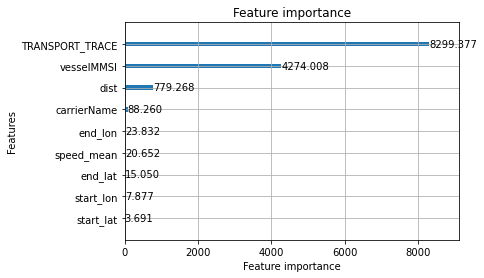

In [72]:
# 预测是测试集的概率
data2 = build_model_adv(data, features, 'is_test', is_shuffle=True)

In [34]:
train = data2[data2['is_test']==0].sort_values(by=['is_test_predict'], ascending=False).reset_index(drop=True)
test = data2[data2['is_test']==1].reset_index(drop=True)

In [38]:
valid = train[:round(train.shape[0]/10)]
train = train[round(train.shape[0]/10):]

In [40]:
valid

,loadingOrder,mmax,count,mmin,label,TRANSPORT_TRACE,carrierName,vesselMMSI,start_lon,end_lon,start_lat,end_lat,dist,speed_mean,is_test,is_test_predict
0,BY502480239351,2019-02-05 19:13:41+00:00,1994,2019-01-24 05:43:25+00:00,1085416.0,75,14,127,3.308472,7.988900,51.917158,58.141683,754090.0,49.546138,0,0.897397
1,ZN414537273233,2019-04-07 10:26:09+00:00,282,2019-04-01 02:33:06+00:00,546783.0,52,14,23,105.363973,96.223813,3.624773,16.689120,1764440.0,11.156028,0,0.663325
2,CU361666889874,2019-03-11 16:03:40+00:00,11669,2019-03-01 17:28:16+00:00,858924.0,62,12,81,115.049250,160.061280,22.036797,36.520400,4610440.0,27.836918,0,0.655989
3,FU974301730521,2020-01-16 07:32:55+00:00,784,2020-01-11 07:28:04+00:00,432291.0,48,12,109,114.115250,139.777883,22.326500,35.611533,2890470.0,23.492347,0,0.619510
4,NI535451490451,2020-06-12 22:12:23+00:00,1490,2020-06-06 15:17:23+00:00,543300.0,88,18,156,9.735113,9.752373,1.824980,2.723920,100090.0,5.213423,0,0.606462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,IK640828991973,2020-06-25 22:26:39+00:00,2551,2020-06-20 23:01:16+00:00,429923.0,256,2,681,113.895033,139.769217,22.454417,35.601967,2899170.0,26.141121,0,0.013199
537,IM873850032436,2019-01-28 12:10:36+00:00,203,2019-01-24 08:19:47+00:00,359449.0,293,9,1185,113.892995,101.356183,22.453590,3.012833,2552570.0,19.408867,0,0.013199
538,TD807835179147,2019-11-19 01:22:41+00:00,322,2019-11-18 18:52:18+00:00,23423.0,228,0,713,113.897020,114.121948,22.461487,22.342158,26690.0,7.562112,0,0.013199
539,IM313928379370,2020-03-03 07:57:20+00:00,2051,2020-02-21 06:28:34+00:00,955726.0,731,10,351,55.067563,32.365863,25.026130,30.397605,2311250.0,18.934666,0,0.013199


以下施工中

In [44]:
features = [c for c in train.columns if c not in ['loadingOrder', 'label', 'mmin', 'mmax', 'count', 'is_test', 'is_test_predict']]
print(features)

['TRANSPORT_TRACE', 'carrierName', 'vesselMMSI', 'start_lon', 'end_lon', 'start_lat', 'end_lat', 'dist', 'speed_mean']


In [58]:
def mse_score_eval(preds, valid):
    labels = valid.get_label()
    scores = mean_squared_error(y_true=labels/3600, y_pred=preds/3600)
    return 'mse_score', scores, False

def build_model_once(train, valid, test, features, label, seed=1080, is_shuffle=True):
    params = {
        'learning_rate': 0.01,
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'num_leaves': 36,
        'feature_fraction': 0.6,
        'bagging_fraction': 0.7,
        'bagging_freq': 6,
        'seed': 8,
        'bagging_seed': 1,
        'feature_fraction_seed': 7,
        'min_data_in_leaf': 20,
        'nthread': 8,
        'verbose': 1,
        'device':'cpu'
    }
    
    # 数据加载
    n_train = lgb.Dataset(train[features], label=train[label])
    n_valid = lgb.Dataset(valid[features], label=valid[label])

    clf = lgb.train(
        params=params,
        train_set=n_train,
        num_boost_round=6000,
        valid_sets=[n_valid],
        early_stopping_rounds=100,
        verbose_eval=100,
        feval=mse_score_eval
    )
    # 打印特征重要度
    lgb.plot_importance(clf, max_num_features = 20, importance_type = 'gain')
    
    test['label'] = clf.predict(test[features], num_iteration=clf.best_iteration)
    
    # print('oof MSE: ',mean_squared_error(train[label]/3600,train_pred/3600))
    print('test_label均值',np.mean(test[label]/3600))
    print('train_label均值',np.mean(train[label]/3600))
    return test[['loadingOrder', 'label']]



Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 3.20265e+11	valid_0's mse_score: 24711.8
[200]	valid_0's l2: 1.49399e+11	valid_0's mse_score: 11527.7
[300]	valid_0's l2: 1.07771e+11	valid_0's mse_score: 8315.69
[400]	valid_0's l2: 9.39642e+10	valid_0's mse_score: 7250.33
[500]	valid_0's l2: 8.76392e+10	valid_0's mse_score: 6762.28
[600]	valid_0's l2: 8.34009e+10	valid_0's mse_score: 6435.25
[700]	valid_0's l2: 8.04796e+10	valid_0's mse_score: 6209.84
[800]	valid_0's l2: 7.86466e+10	valid_0's mse_score: 6068.41
[900]	valid_0's l2: 7.70563e+10	valid_0's mse_score: 5945.7
[1000]	valid_0's l2: 7.61301e+10	valid_0's mse_score: 5874.23
[1100]	valid_0's l2: 7.52939e+10	valid_0's mse_score: 5809.71
[1200]	valid_0's l2: 7.48129e+10	valid_0's mse_score: 5772.6
[1300]	valid_0's l2: 7.38427e+10	valid_0's mse_score: 5697.74
[1400]	valid_0's l2: 7.37555e+10	valid_0's mse_score: 5691.01
[1500]	valid_0's l2: 7.31605e+10	valid_0's mse_score: 5645.1
[1600]	valid_0's l2:

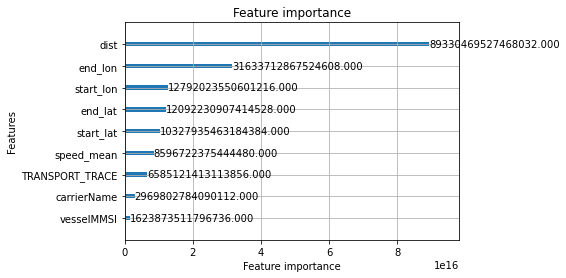

In [59]:
# baseline
result = build_model_once(train, valid, test, features, 'label', is_shuffle=True)

In [55]:
# 拼接结果文件，符合格式要求
result_data= pd.read_csv('data/R2 ATest 0711.csv')
result_data = result_data.merge(result, on='loadingOrder', how='left')
result_data = get_data(result_data, mode='test')  # 转换格式
result_data['ETA'] = (result_data['onboardDate'] + result_data['label'].apply(lambda x:pd.Timedelta(seconds=x))).apply(lambda x:x.strftime('%Y/%m/%d  %H:%M:%S'))
result_data.drop(['direction','TRANSPORT_TRACE'],axis=1,inplace=True)
result_data['onboardDate'] = result_data['onboardDate'].apply(lambda x:x.strftime('%Y/%m/%d  %H:%M:%S'))
result_data['creatDate'] = pd.datetime.now().strftime('%Y/%m/%d  %H:%M:%S')
result_data['timestamp'] = result_data['temp_timestamp']
# 整理columns顺序
result = result_data[['loadingOrder', 'timestamp', 'longitude', 'latitude', 'carrierName', 'vesselMMSI', 'onboardDate', 'ETA', 'creatDate']]

D:\Tools\Python\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  import sys


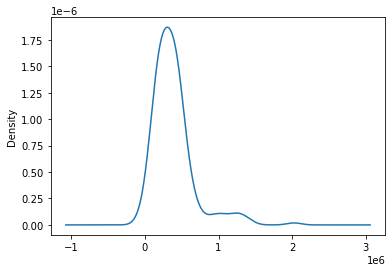

In [56]:
# 计算label分布
def cal_label(best):
    onboardDate = best.groupby('loadingOrder')['onboardDate'].agg(mmax='max').reset_index()
    ETA=best.groupby('loadingOrder')['ETA'].agg(mmax='max').reset_index()
    return (pd.to_datetime(ETA['mmax'])-pd.to_datetime(onboardDate['mmax'])).dt.total_seconds()
# baseline
new=cal_label(result)
new.plot(kind='kde')
plt.show()

In [57]:
# 生成结果
import datetime
now = datetime.datetime.now()
result.to_csv('result/result_{0}-{1}-{2}_{3}-{4}.csv'.format(now.year,now.month,now.day,now.hour,now.minute), index=False)

[0.21681197 0.15224397]


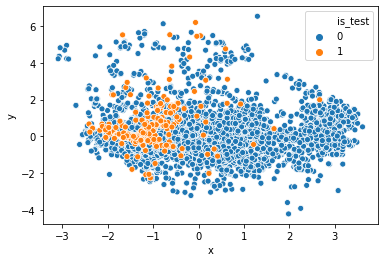

In [64]:
# 将特征PCA降维至二维观察
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for i in features:
    data2[i].fillna(method='ffill',inplace=True)
    data2[i] = scaler.fit_transform(data2[i].values.reshape(-1, 1))
    
from sklearn.decomposition import PCA
pca = PCA(2)
X_embedded = pca.fit_transform(data2[features].values)
print(pca.explained_variance_ratio_)

pca_df = pd.DataFrame(columns=['is_test','x','y'])
pca_df['is_test'] = data2['is_test']
pca_df[['x','y']] = X_embedded

sns.scatterplot(data=pca_df,x='x',y='y',hue='is_test')


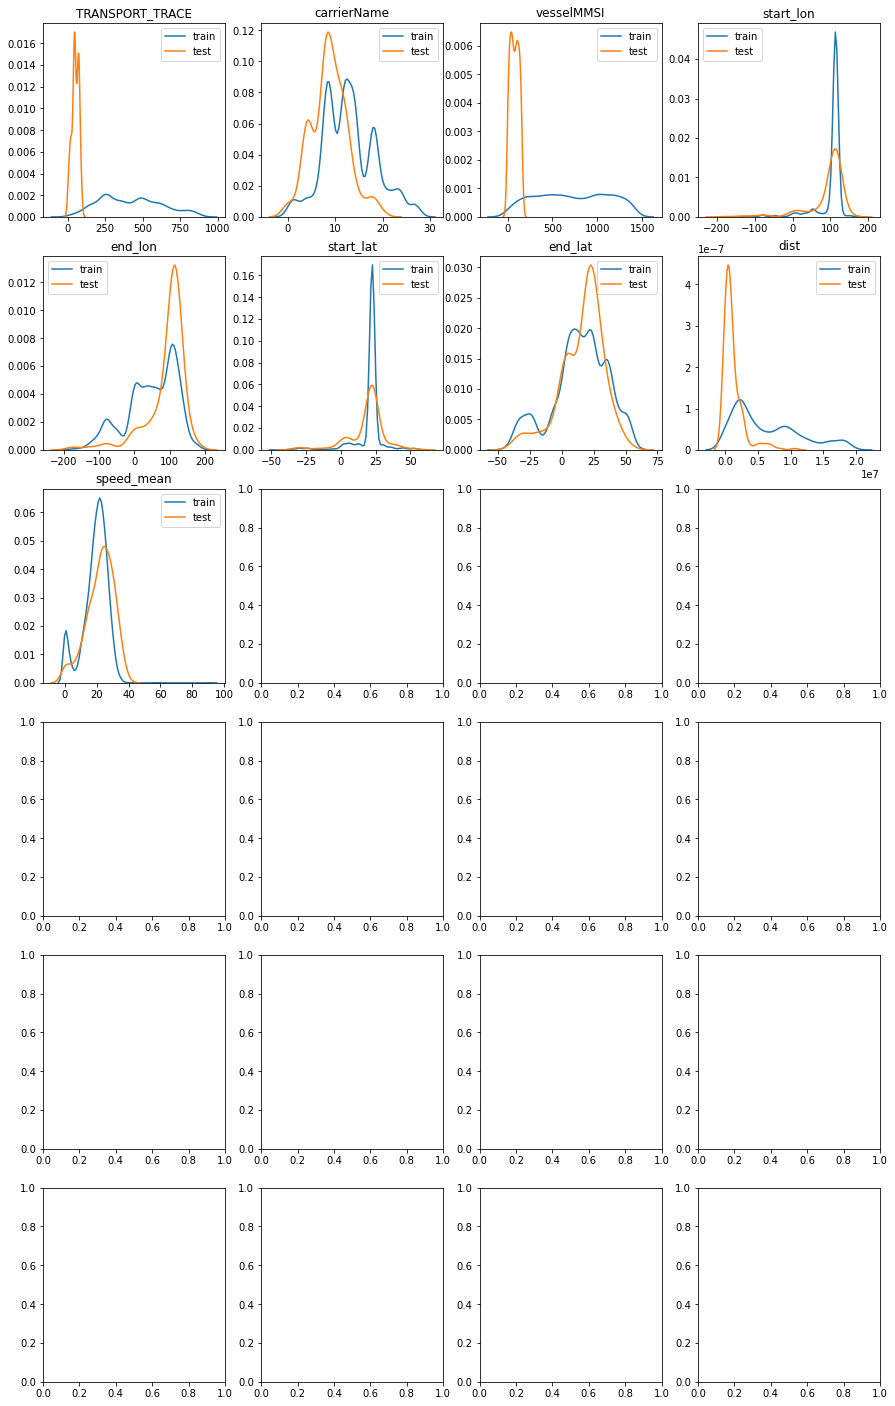

In [69]:
# 查看训练集与测试集特征分布
plt.subplots(6,4,figsize=(15,25))
for idx,col in enumerate(test.columns[5:14]):
    try:
        plt.subplot(6,4,idx+1)
        plt.title(col)
        sns.kdeplot(train[col],label='train')
        sns.kdeplot(test[col],label='test')
    except:
        pass